In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd
from scipy import interpolate
import pickle

import xmeos
from xmeos import models
from xmeos import datamod
from xmeos import eoslib

from collections import OrderedDict
CONSTS = models.CONSTS

In [2]:
# from xmeos import eoslib
# eos_mod = eoslib.MgSiO3_RTPress()


In [3]:
analysis_file = 'data/analysis.pkl'
with open(analysis_file, 'rb') as f:
    analysis = pickle.load(f)

In [4]:
eos_electronic = analysis['eos_electronic']
datamodel = analysis['datamodel']
data = datamodel['data']
eos_mod = datamodel['eos_mod']

props_Lange = analysis['props_Lange']
props_Ghiorso = analysis['props_Ghiorso']

In [15]:
datamodel_dK09 = analysis['datamodel_dK09']
eos_mod_dK09 = datamodel_dK09['eos_mod']

In [16]:
eos_mod.apply_electronic = True
eos_mod_dK09.apply_electronic = True

In [17]:
display(eos_mod.material_properties(props_Lange['P'],props_Lange['T']))
display(props_Lange)

OrderedDict([('P', 0),
             ('T', 1673),
             ('V', 11.790827550351612),
             ('KT', 10.487930644160759),
             ('KS', 10.871889894046701),
             ('Cv', array([ 4.25430641])),
             ('therm_exp', 0.00010195032601739767),
             ('gamma', 0.21464005351665716)])

{'KT': 19.3500111762087,
 'P': 0,
 'T': 1673,
 'V': 12.803751383249672,
 'alpha': 8.481830207765933e-05,
 'betaT': 0.05167955671413378,
 'dVdT': 0.001635}

In [42]:
display(eos_mod_dK09.material_properties(props_Lange['P'],props_Lange['T']))

OrderedDict([('P', 0),
             ('T', 1673),
             ('V', 12.458559271126456),
             ('KT', 21.361020647368001),
             ('KS', 22.98784567015749),
             ('Cv', array([ 4.83182827])),
             ('therm_exp', 0.00010682277976992501),
             ('gamma', 0.42614660016777356)])

# Load Shock wave data

In [18]:
shock_dat = pd.read_csv('data/shock-data-Mosenfelder2009.csv',delimiter=',')
melt_en_mask = ((shock_dat['Starting Material']=='Enstatite')&(shock_dat['Phase State']=='melt'))
melt_glass_mask = ((shock_dat['Starting Material']=='Glass')&(shock_dat['Phase State']=='melt'))

melt_enpor_mask = ((shock_dat['Starting Material']=='Porous Enstatite')&(shock_dat['Phase State']=='melt'))
melt_oxmix_mask = ((shock_dat['Starting Material']=='Oxide mix')&(shock_dat['Phase State']=='melt'))



In [19]:
shock_dat.head()

,Starting Material,Reference,Shot,Flyer Material,Ufp,Ufp err,rho0,rho0 err,Us,Us err,Up,Up err,P,P err,rho,rho err,TH,TH err,Phase State
0,Pv77Mj23c,this study,370.0,Al 1100,6.13,0.01,3.970,0.021,10.81,0.12,2.42,0.02,104.0,0.8,5.12,0.03,NaN,NaN,Pv
1,Pv77Mj23,this study,367.0,Cu,5.09,0.01,3.973,0.030,11.76,0.16,2.94,0.02,137.4,1.5,5.30,0.05,NaN,NaN,Pv
2,Pv75Mj25,this study,366.0,Ta,5.17,0.01,3.958,0.013,12.14,0.10,3.41,0.02,163.8,1.2,5.51,0.03,NaN,NaN,Pv
3,Pv86Mj14,this study,368.0,Cu,6.32,0.01,4.025,0.016,12.71,0.14,3.67,0.02,187.4,1.7,5.66,0.04,NaN,NaN,Pv
4,Pv80Mj20,this study,369.0,Ta,6.96,0.01,3.989,0.012,13.28,0.14,4.63,0.02,245.4,2.2,6.13,0.05,NaN,NaN,PPv


In [20]:


# hugoniot_glass_d = calc_hugoniot( rhofaclims_glass, rhoinit_glass, Tinit, eos_d, Etrans=Etrans_glass)

# Enstatite Hugoniot
rhoinit_en=np.mean(shock_dat['rho0'][melt_en_mask])
rhofaclims_en = [1.59, 1.84]
# Etrans_en = 2.192455e6*1e-3/const_d['JperHa']*const_d['eVperHa']*eos_d['param_d']['mass_avg']/const_d['Nmol']
Tmelt_en = 1816
#Tmelt_en = 300
Efus_en = 73*1e3/5/CONSTS['JperHa']*CONSTS['eVperHa']/CONSTS['Nmol']
Eheat_en = 126*(Tmelt_en-273)/5/CONSTS['JperHa']*CONSTS['eVperHa']/CONSTS['Nmol']
Etrans_en = Eheat_en+Efus_en


# hugoniot_en_d = calc_hugoniot_RTgrid( [6.3,14.0], rhoinit_en, Tinit, RTgrid_d, eos_d, Etrans=Etrans_en, Ttrans=Tmelt_en )
# hugoniot_dk_en_d = calc_hugoniot_RTgrid( [6.3,14.0], rhoinit_en, Tinit, RTgrid_dk_d, eos_d, Etrans=Etrans_en, Ttrans=Tmelt_en )


# Glass Hugoniot
rhoinit_glass = np.mean(shock_dat['rho0'][melt_glass_mask])
rhofaclims_glass = [1.65, 1.94]
# Etrans_glass = 1.862455e6*1e-3/const_d['JperHa']*const_d['eVperHa']*eos_d['param_d']['mass_avg']/const_d['Nmol']
delE_glass = (2.192455e6-1.862455e6)*1e-3/CONSTS['JperHa']*CONSTS['eVperHa']*eos_mod.molar_mass/CONSTS['Nmol']
Etrans_glass = Etrans_en - delE_glass


# # Porous Hugoniots
# delE_oxmix = (2.192455e6-1.952455e6)*1e-3/const_d['JperHa']*const_d['eVperHa']*eos_d['param_d']['mass_avg']/const_d['Nmol']
# rhoinit_oxmix = np.mean(shock_dat['rho0'][melt_oxmix_mask])
# Etrans_oxmix = Etrans_en - delE_oxmix

rhoinit_enpor=np.mean(shock_dat['rho0'][melt_enpor_mask])
# hugoniot_glass_d = calc_hugoniot_RTgrid( [6.3,14.0], rhoinit_glass, Tinit, RTgrid_d, eos_d, Etrans=Etrans_glass, Ttrans=Tmelt_en )
# hugoniot_dk_glass_d = calc_hugoniot_RTgrid( [6.3,14.0], rhoinit_glass, Tinit, RTgrid_dk_d, eos_d, Etrans=Etrans_glass, Ttrans=Tmelt_en )


In [22]:
Tinit = 300

rhofaclims_en = np.array([1.6, 1.8])
hugoniot_en = eos_mod.hugoniot(rhofaclims_en, rhoinit_en, Tinit, 
                               Etrans=Etrans_en, Ttrans=Tmelt_en, 
                               isobar_trans=True)

hugoniot_en_dK09 = eos_mod_dK09.hugoniot(rhofaclims_en, rhoinit_en, Tinit, 
                               Etrans=Etrans_en, Ttrans=Tmelt_en, 
                               isobar_trans=True)
# hugoniot_en

rhofaclims_glass = [1.65, 1.9]
hugoniot_glass = eos_mod.hugoniot(rhofaclims_glass, rhoinit_glass, Tinit, 
                                  Etrans=Etrans_glass, Ttrans=Tmelt_en, 
                                  isobar_trans=True)



hugoniot_glass_dK09 = eos_mod_dK09.hugoniot(rhofaclims_glass, rhoinit_glass, Tinit, 
                                  Etrans=Etrans_glass, Ttrans=Tmelt_en, 
                                  isobar_trans=True)
# rhofaclims_oxmix = [2.1, 2.55]
# hugoniot_oxmix_d = calc_hugoniot( rhofaclims_oxmix, rhoinit_oxmix, Tinit, eos_d, Etrans=Etrans_oxmix, Ttrans=Tmelt_en, isobar_trans=True)
# hugoniot_dk_oxmix_d = calc_hugoniot( rhofaclims_oxmix, rhoinit_oxmix, Tinit, miegrun_dk_d, Etrans=Etrans_oxmix, Ttrans=Tmelt_en, isobar_trans=True)




/Users/aswolf/anaconda/envs/py36/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<IPython.core.display.Javascript object>


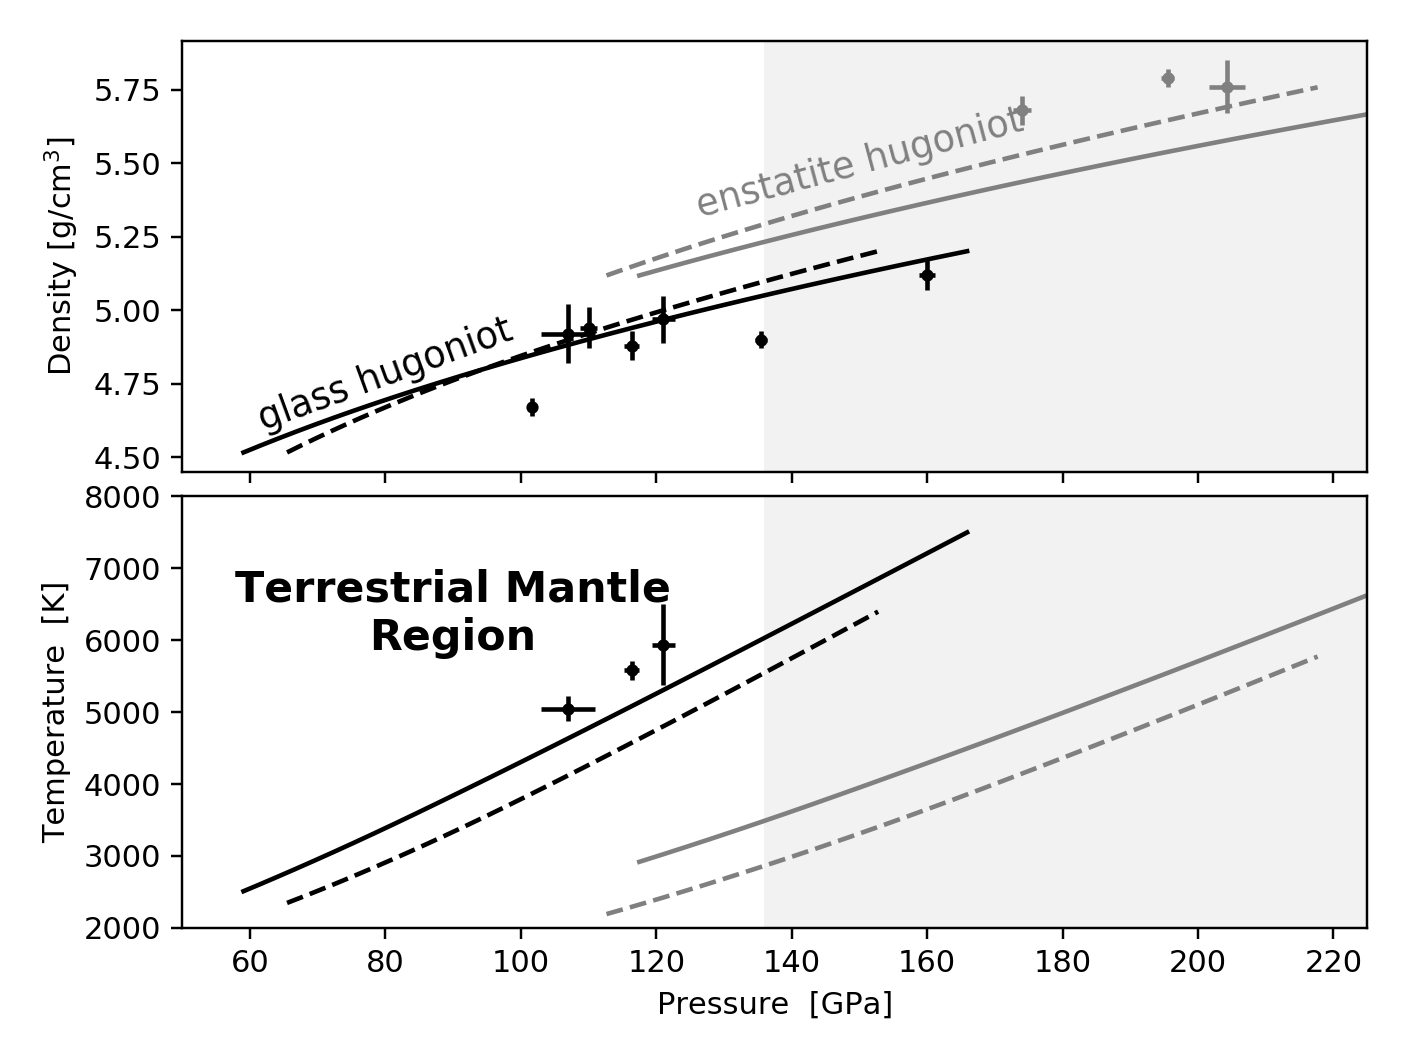

In [27]:
#############################
# Plot Hugoniot Comparison
#############################

Plim = [50,225]
col_glass = [0,0,0]
col_en = [.65,.65,.65]
col_en = [.5,.5,.5]
f, ax_a = plt.subplots(2, 1, sharex='col')

ax_a[0].errorbar(shock_dat['P'][melt_glass_mask], shock_dat['rho'][melt_glass_mask],
             xerr=shock_dat['P err'][melt_glass_mask],
             yerr=shock_dat['rho err'][melt_glass_mask],fmt='.',color=col_glass)
ax_a[0].errorbar(shock_dat['P'][melt_en_mask], shock_dat['rho'][melt_en_mask],
             xerr=shock_dat['P err'][melt_en_mask],
             yerr=shock_dat['rho err'][melt_en_mask],fmt='.',color=col_en)
# ax_a[0].errorbar(shock_dat['P'][melt_enpor_mask], shock_dat['rho'][melt_enpor_mask],
#              xerr=shock_dat['P err'][melt_enpor_mask],
#              yerr=shock_dat['rho err'][melt_enpor_mask],fmt='m.')
# ax_a[0].errorbar(shock_dat['P'][melt_oxmix_mask], shock_dat['rho'][melt_oxmix_mask],
#              xerr=shock_dat['P err'][melt_oxmix_mask],
#              yerr=shock_dat['rho err'][melt_oxmix_mask],fmt='g.')

ax_a[0].plot(hugoniot_glass['P_a'],hugoniot_glass['rho_a'],'-',color=col_glass)
ax_a[0].plot(hugoniot_en['P_a'],hugoniot_en['rho_a'],'-',color=col_en)

ax_a[0].plot(hugoniot_glass_dK09['P_a'],hugoniot_glass_dK09['rho_a'],'--',color=col_glass)
ax_a[0].plot(hugoniot_en_dK09['P_a'],hugoniot_en_dK09['rho_a'],'--',color=col_en)

# ax_a[0].plot(hugoniot_dk_glass_d['P_a'],hugoniot_dk_glass_d['rho_a'],'--',color=col_glass)
# ax_a[0].plot(hugoniot_dk_en_d['P_a'],hugoniot_dk_en_d['rho_a'],'--',color=col_en)

ax_a[0].set_xlim(Plim[0],Plim[1])
ax_a[0].set_ylabel(u'Density [g/cm$^3$]')

ax_a[1].plot(hugoniot_glass['P_a'],hugoniot_glass['T_a'],'-',color=col_glass)
ax_a[1].plot(hugoniot_en['P_a'],hugoniot_en['T_a'],'-',color=col_en)

ax_a[1].plot(hugoniot_glass_dK09['P_a'],hugoniot_glass_dK09['T_a'],'--',color=col_glass)
ax_a[1].plot(hugoniot_en_dK09['P_a'],hugoniot_en_dK09['T_a'],'--',color=col_en)

# ax_a[1].plot(hugoniot_dk_glass_d['P_a'],hugoniot_dk_glass_d['T_a'],'--',color=col_glass)
# ax_a[1].plot(hugoniot_dk_en_d['P_a'],hugoniot_dk_en_d['T_a'],'--',color=col_en)

ax_a[1].errorbar(shock_dat['P'][melt_glass_mask], shock_dat['TH'][melt_glass_mask],
                 xerr=shock_dat['P err'][melt_glass_mask],
                 yerr=shock_dat['TH err'][melt_glass_mask],fmt='.',color=col_glass)
ax_a[1].errorbar(shock_dat['P'][melt_en_mask], shock_dat['TH'][melt_en_mask],
             xerr=shock_dat['P err'][melt_en_mask],
             yerr=shock_dat['TH err'][melt_en_mask],fmt='.',color=col_en)

ax_a[1].set_xlim(Plim[0],Plim[1])
ax_a[1].set_xlabel('Pressure  [GPa]')
ax_a[1].set_ylabel('Temperature  [K]')

ax_a[1].set_ylim(2000,8000)



ax_a[0].text(80,4.78,'glass hugoniot',fontsize=12,color=col_glass,
             verticalalignment='center',horizontalalignment='center',rotation=20)
ax_a[0].text(150,5.5,'enstatite hugoniot',fontsize=12,color=col_en,
             verticalalignment='center',horizontalalignment='center',rotation=15)

# ax_a[0].plot(136*np.ones(2),ax_a[0].get_ylim(),'r:',lw=2)
# ax_a[1].plot(136*np.ones(2),ax_a[1].get_ylim(),'r:',lw=2)

ax_a[0].axvspan(136,Plim[1],color = [.95,.95,.95])
ax_a[1].axvspan(136,Plim[1],color = [.95,.95,.95])

# ax_a[0].axvspan(50,136,color = [1,.9,.9])
# ax_a[1].axvspan(50,136,color = [1,.9,.9])

# ax_a[0].text(90,5.75,'Terrestrial Mantle Region',fontsize=14,color='k',
#              horizontalalignment='center')
# ax_a[1].text(90,7000,'Earth-like Mantle Region',fontsize=14,color='k',
#              horizontalalignment='center')
# ax_a[0].text(90,5.75,'Terrestrial Mantle Region',fontsize=14,color='k',
#              horizontalalignment='center')
# ax_a[1].text(90,7000,'Terrestrial Mantle Region',fontsize=14,color='k',
#              horizontalalignment='center')
ax_a[1].text(90,7000,'Terrestrial Mantle\nRegion',fontsize=14,color='k',
             verticalalignment='top',horizontalalignment='center',weight='bold')

plt.draw()
plt.tight_layout(h_pad=.15)


# plt.savefig('figs/MgSiO3-hugoniot-compare.eps')
# plt.savefig('figs/MgSiO3-hugoniot-compare.png',dpi=450)

In [38]:

# Tfoot_grid = np.arange(2000,9001,1000)
Tlbl = [2000,2250,2500,2750,3000,3250,3500]
delT = Tlbl[1]-Tlbl[0]
Tfoot_grid = Tlbl
Pgrid = np.arange(0,550.1,1)
eos_mod.apply_electronic = True
Vad_grid, Tad_grid = eos_mod.adiabatic_path_grid(Tfoot_grid, Pgrid)

eos_mod_dK09.apply_electronic = True
Vad_grid_dK09, Tad_grid_dK09 = eos_mod_dK09.adiabatic_path_grid(Tfoot_grid, Pgrid)

[1875.0, 3625.0]


<IPython.core.display.Javascript object>


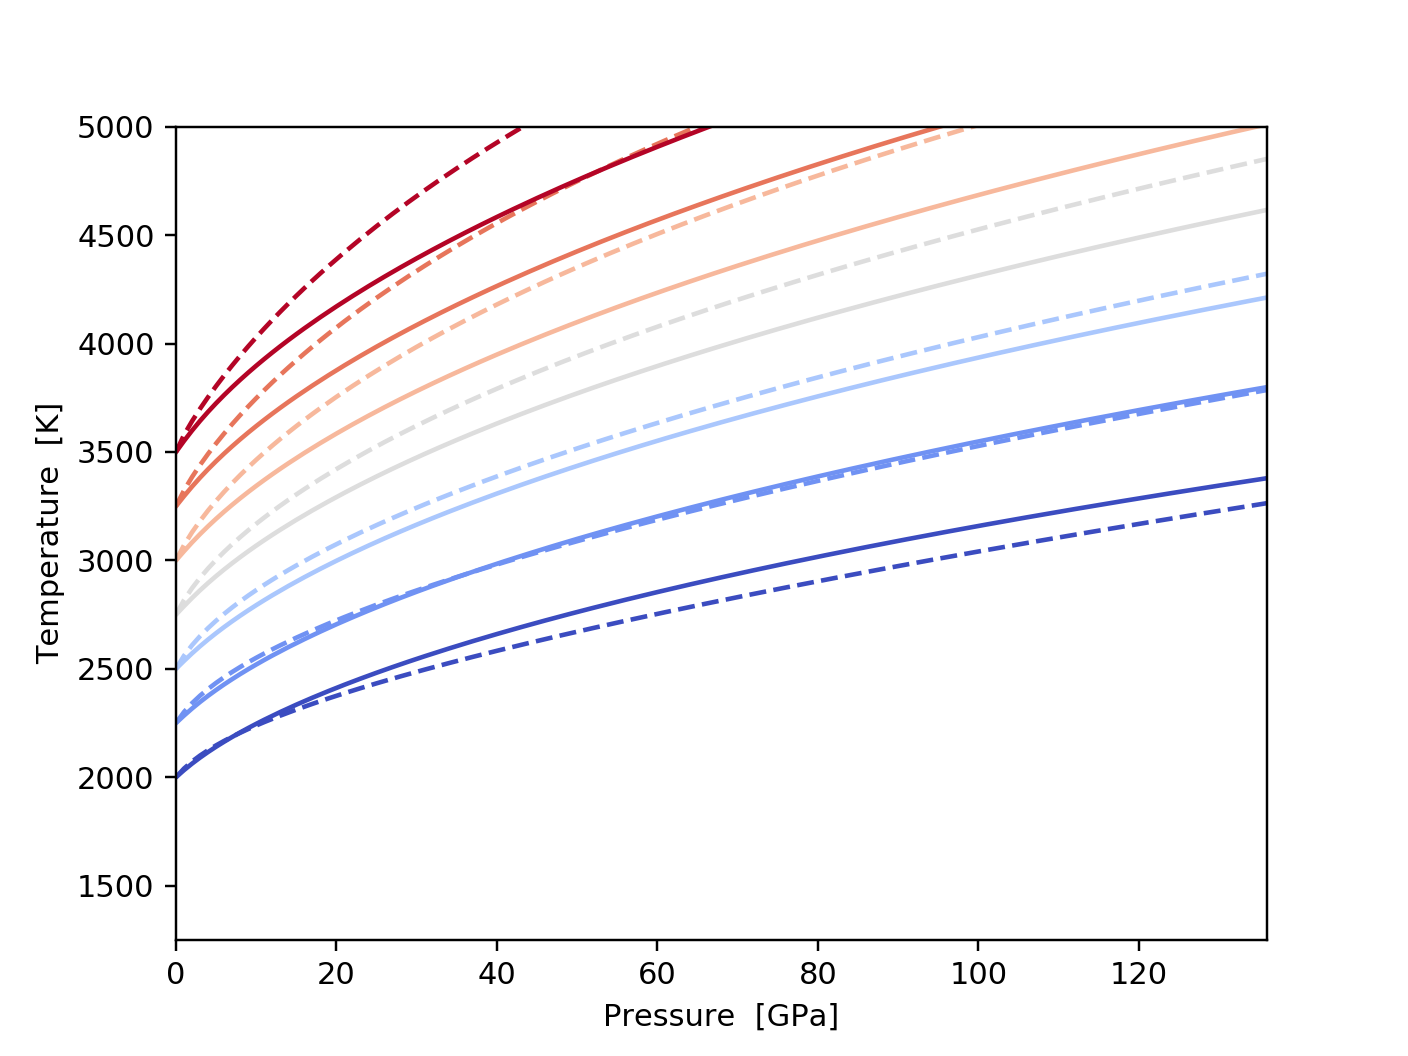

In [39]:

cmap = plt.get_cmap('coolwarm',len(Tlbl))
clims = [Tlbl[0]-delT/2,Tlbl[-1]+delT/2]
print(clims)
plt.figure()


for iT, Tad, Tad_dK09 in zip(Tlbl, Tad_grid, Tad_grid_dK09):
    icol = cmap((iT-clims[0])/(clims[1]-clims[0]))
    plt.plot(Pgrid, Tad, '-', color=icol)
    plt.plot(Pgrid, Tad_dK09, '--', color=icol)
    
    
plt.ylim(1250,5000)
plt.xlim(0,136)
plt.xlabel('Pressure  [GPa]')
plt.ylabel('Temperature  [K]')


<IPython.core.display.Javascript object>


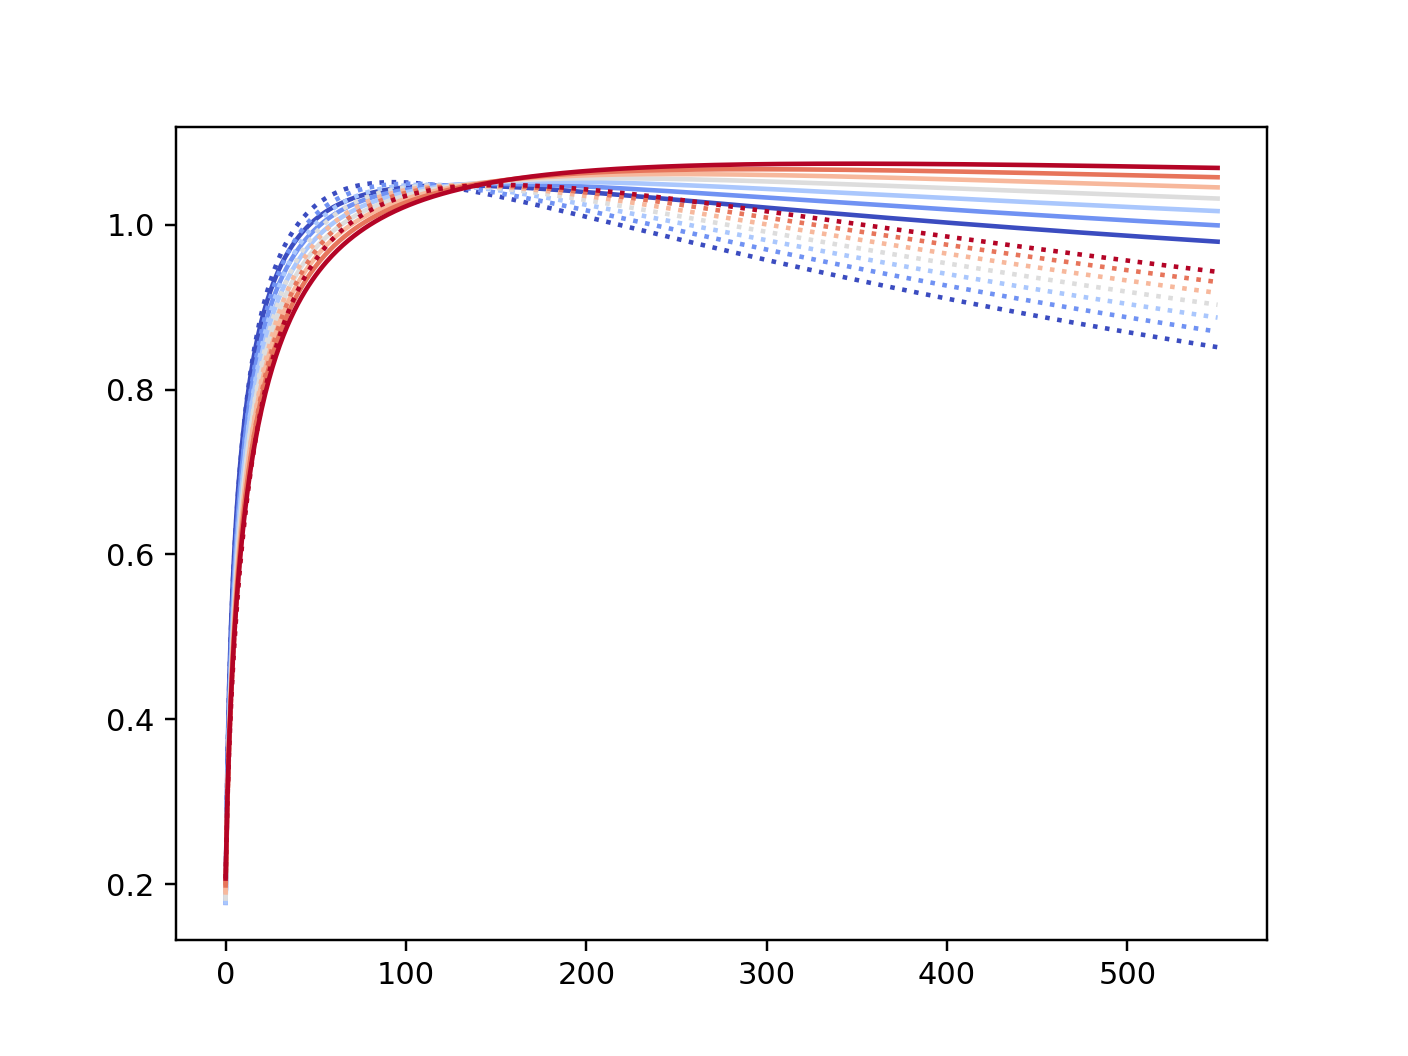

<IPython.core.display.Javascript object>


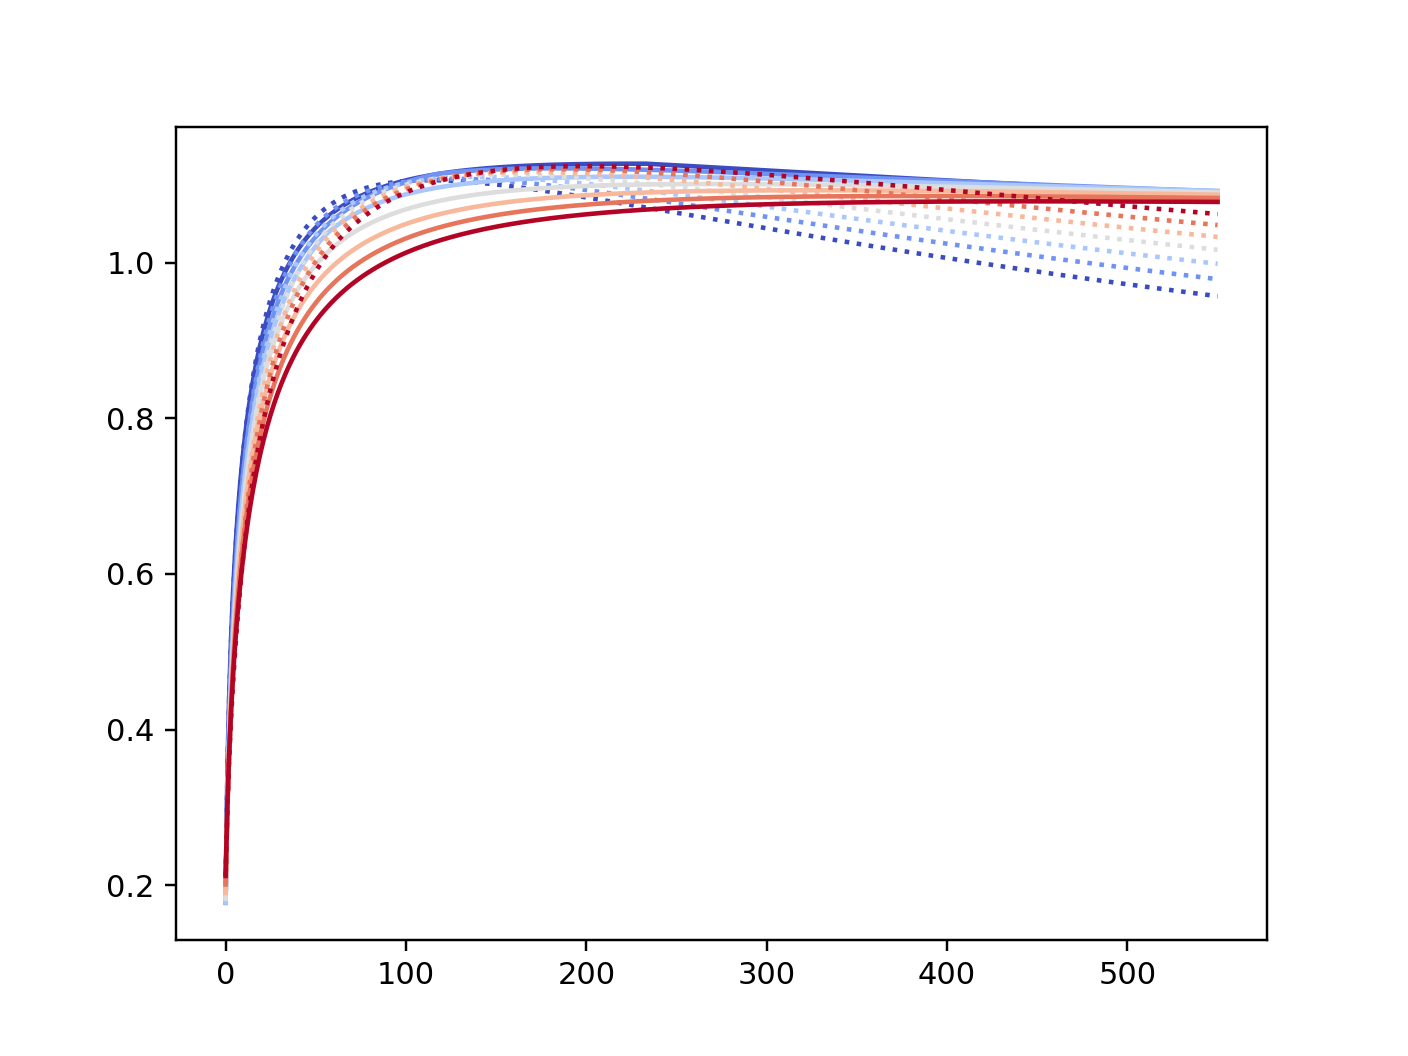

In [40]:
eos_mod.apply_electronic = False

plt.figure()
for Vad, Tad, iTpot in zip(Vad_grid, Tad_grid, Tlbl):
    icol = cmap((iTpot-clims[0])/(clims[1]-clims[0]))
    igamma_ad = eos_mod.gamma(Vad,Tad)
    igamma_T = eos_mod.gamma(Vad, iTpot)
    plt.plot(Pgrid,igamma_ad, '-', color=icol)
    plt.plot(Pgrid,igamma_T, ':', color=icol)
   
eos_mod.apply_electronic = True

plt.figure()
for Vad, Tad, iTpot in zip(Vad_grid, Tad_grid, Tlbl):
    icol = cmap((iTpot-clims[0])/(clims[1]-clims[0]))
    igamma_ad = eos_mod.gamma(Vad,Tad)
    igamma_T = eos_mod.gamma(Vad, iTpot)
    plt.plot(Pgrid,igamma_ad, '-', color=icol)
    plt.plot(Pgrid,igamma_T, ':', color=icol)


<IPython.core.display.Javascript object>


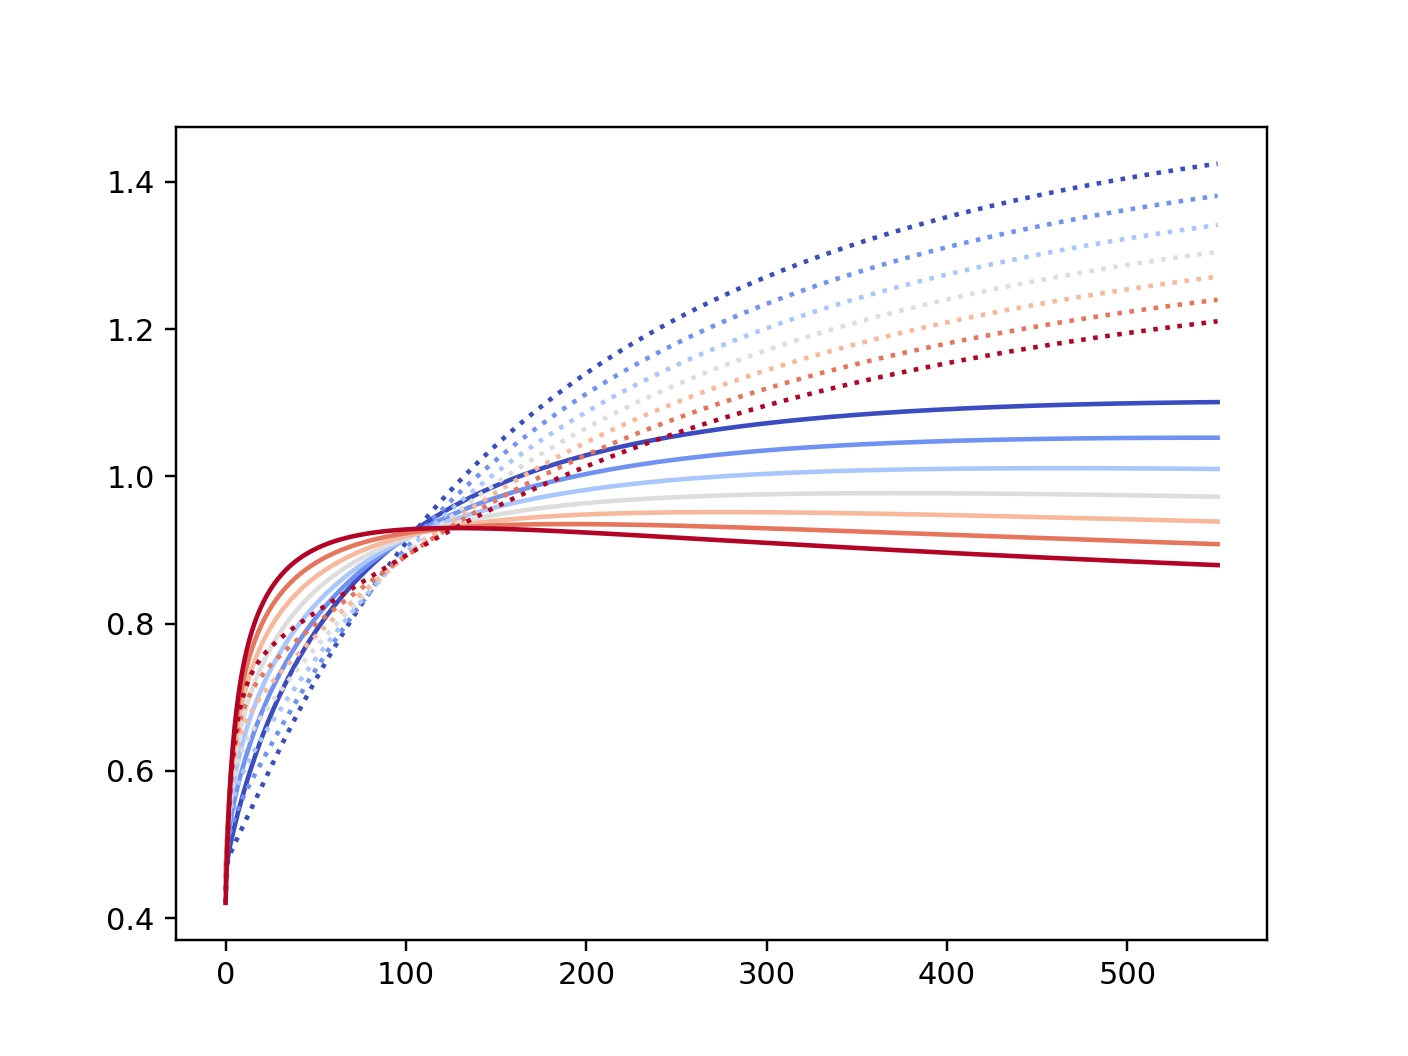

<IPython.core.display.Javascript object>


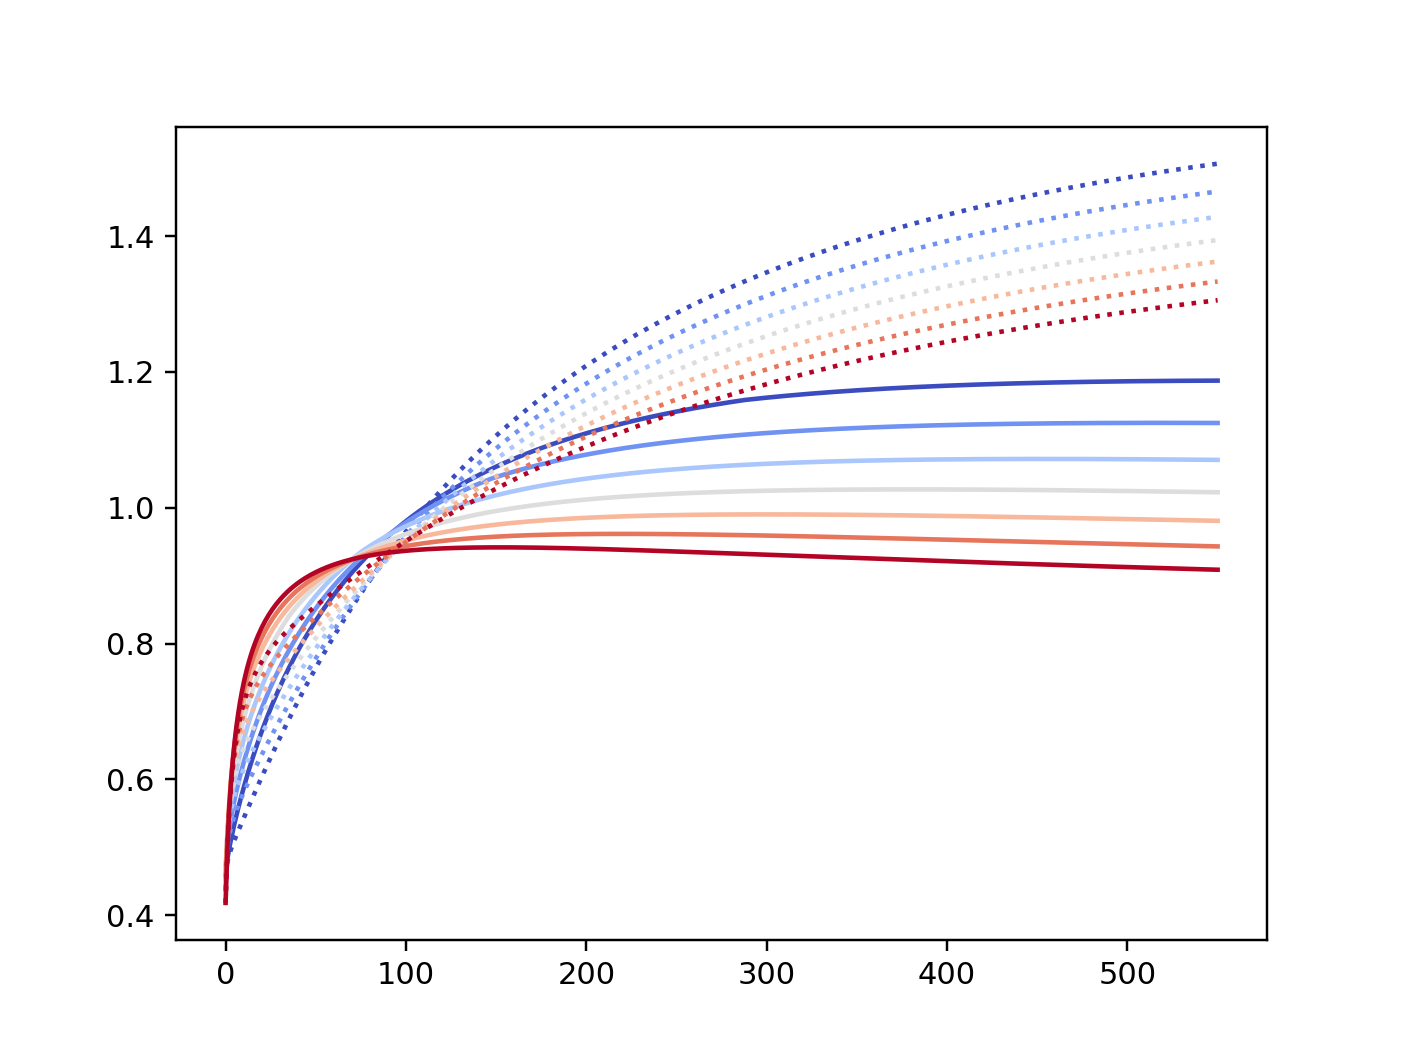

In [41]:

eos_mod_dK09.apply_electronic = False

plt.figure()
for Vad, Tad, iTpot in zip(Vad_grid, Tad_grid, Tlbl):
    icol = cmap((iTpot-clims[0])/(clims[1]-clims[0]))
    igamma_ad = eos_mod_dK09.gamma(Vad,Tad)
    igamma_T = eos_mod_dK09.gamma(Vad, iTpot)
    plt.plot(Pgrid,igamma_ad, '-', color=icol)
    plt.plot(Pgrid,igamma_T, ':', color=icol)
   
eos_mod_dK09.apply_electronic = True

plt.figure()
for Vad, Tad, iTpot in zip(Vad_grid, Tad_grid, Tlbl):
    icol = cmap((iTpot-clims[0])/(clims[1]-clims[0]))
    igamma_ad = eos_mod_dK09.gamma(Vad,Tad)
    igamma_T = eos_mod_dK09.gamma(Vad, iTpot)
    plt.plot(Pgrid,igamma_ad, '-', color=icol)
    plt.plot(Pgrid,igamma_T, ':', color=icol)


In [28]:
#eos_mod = eoslib.MgSiO3_deKoker2009_PTherm()
#eos_mod.get_params()

<IPython.core.display.Javascript object>


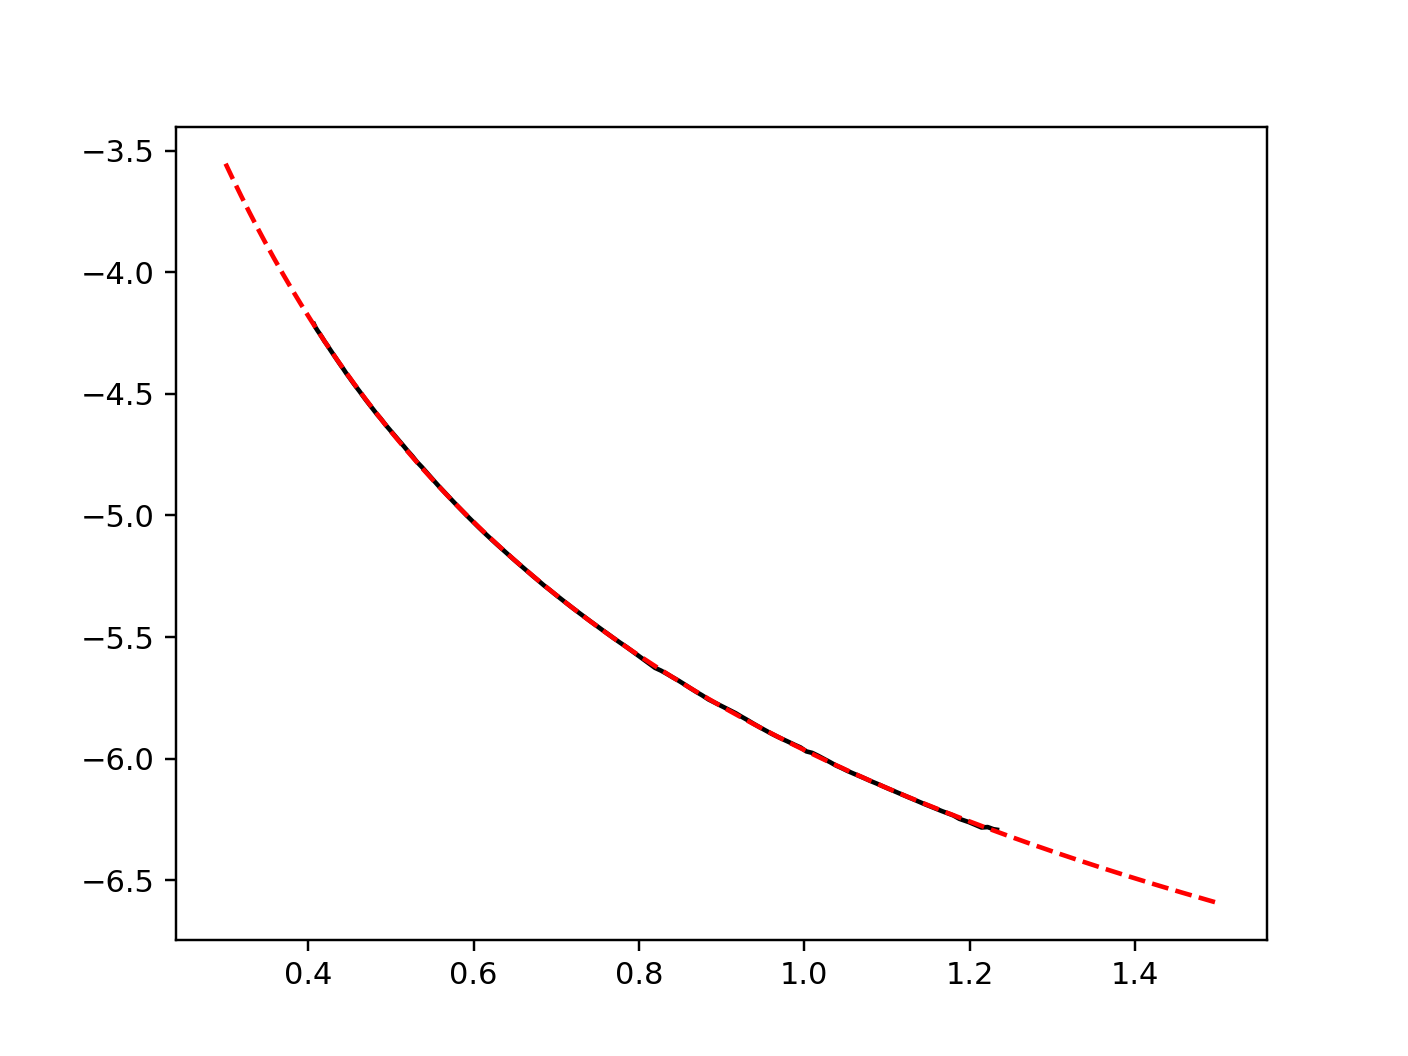

array([-5.96467796, -1.66870847,  0.32322974, -0.04433057, -0.07772874,
       -0.00781603])

In [7]:
dirnm = 'data/'
order = 5
Ptherm_dK09_a = np.loadtxt(dirnm+'MgSiO3-Ptherm-deKoker2009.csv', skiprows=1, delimiter=',')
Eref_dK09_a = np.loadtxt(dirnm+'MgSiO3-E3000-deKoker2009.csv', skiprows=1, delimiter=',')
Vfrac = Ptherm_dK09_a[:,0]
Pth = Ptherm_dK09_a[:,1]

Vmod = np.linspace(.3,1.5,1001)

# Pth_coef = np.polyfit(Vfrac-1,np.log(Pth),order)
Pth_coef = np.polyfit(np.log(Vfrac),np.log(Pth),order)
plt.figure()
#plt.plot(Vfrac, Pth,'k-', Vmod, np.exp(np.polyval(Pth_coef, Vmod-1)), 'r--')
# plt.plot(Vfrac, np.log(Pth),'k-', Vmod, (np.polyval(Pth_coef, Vmod-1)), 'r--')
plt.plot(Vfrac, np.log(Pth),'k-', Vmod, (np.polyval(Pth_coef, np.log(Vmod))), 'r--')
# plt.plot(Eref_dK09_a[:,0],Eref_dK09_a[:,1],'g-')

Pth_coef[::-1]


In [8]:
plt.gca().set_yscale

<bound method _AxesBase.set_yscale of <matplotlib.axes._subplots.AxesSubplot object at 0x1144cf048>>

In [9]:
plt.gca().set_yscale

<bound method _AxesBase.set_yscale of <matplotlib.axes._subplots.AxesSubplot object at 0x1144cf048>>

In [10]:
analysis_file = 'data/analysis.pkl'
with open(analysis_file, 'rb') as f:
    analysis = pickle.load(f)

In [11]:
eos_electronic = analysis['eos_electronic']
datamodel = analysis['datamodel']
data = datamodel['data']
eos_mod = datamodel['eos_mod']

props_Lange = analysis['props_Lange']
props_Ghiorso = analysis['props_Ghiorso']

# Set electronic model params from deKoker2009

In [12]:
"""electronic_params = list(eos_electronic.get_params().keys())
try:
    electronic_params.remove('V0')
except:
    pass

eos_mod.set_param_values(param_names=electronic_params, 
                         param_values=eos_electronic.get_param_values(
                             param_names=electronic_params))
eos_mod.apply_electronic = True
"""

"electronic_params = list(eos_electronic.get_params().keys())\ntry:\n    electronic_params.remove('V0')\nexcept:\n    pass\n\neos_mod.set_param_values(param_names=electronic_params, \n                         param_values=eos_electronic.get_param_values(\n                             param_names=electronic_params))\neos_mod.apply_electronic = True\n"

In [13]:
from xmeos import eoslib
eos_mod = eoslib.MgSiO3_RTPress()


/Users/aswolf/Documents/projects/xmeos/xmeos/models/composite.py:1732: RuntimeWarning: divide by zero encountered in remainder
  if ((not np.isscalar(order)) | (order < 0) | (np.mod(order,0) !=0)):


In [14]:
display(eos_mod.material_properties(props_Lange['P'],props_Lange['T']))
display(props_Lange)

OrderedDict([('P', 0),
             ('T', 1673),
             ('V', 11.790821304727348),
             ('KT', 10.487908190133233),
             ('KS', 10.90670367171583),
             ('Cv', array([ 4.25430598])),
             ('therm_exp', 0.00010647510290213468),
             ('gamma', 0.22416566896372617)])

{'KT': 19.3500111762087,
 'P': 0,
 'T': 1673,
 'V': 12.803751383249672,
 'alpha': 8.481830207765933e-05,
 'betaT': 0.05167955671413378,
 'dVdT': 0.001635}

In [18]:
eoslib.MgSiO3_deKoker2009_Lookup()

AttributeError: module 'xmeos.eoslib' has no attribute 'MgSiO3_deKoker2009_Lookup'

# Load Shock wave data

In [19]:
shock_dat = pd.read_csv('data/shock-data-Mosenfelder2009.csv',delimiter=',')
melt_en_mask = ((shock_dat['Starting Material']=='Enstatite')&(shock_dat['Phase State']=='melt'))
melt_glass_mask = ((shock_dat['Starting Material']=='Glass')&(shock_dat['Phase State']=='melt'))

melt_enpor_mask = ((shock_dat['Starting Material']=='Porous Enstatite')&(shock_dat['Phase State']=='melt'))
melt_oxmix_mask = ((shock_dat['Starting Material']=='Oxide mix')&(shock_dat['Phase State']=='melt'))



In [20]:
shock_dat.head()

,Starting Material,Reference,Shot,Flyer Material,Ufp,Ufp err,rho0,rho0 err,Us,Us err,Up,Up err,P,P err,rho,rho err,TH,TH err,Phase State
0,Pv77Mj23c,this study,370.0,Al 1100,6.13,0.01,3.970,0.021,10.81,0.12,2.42,0.02,104.0,0.8,5.12,0.03,NaN,NaN,Pv
1,Pv77Mj23,this study,367.0,Cu,5.09,0.01,3.973,0.030,11.76,0.16,2.94,0.02,137.4,1.5,5.30,0.05,NaN,NaN,Pv
2,Pv75Mj25,this study,366.0,Ta,5.17,0.01,3.958,0.013,12.14,0.10,3.41,0.02,163.8,1.2,5.51,0.03,NaN,NaN,Pv
3,Pv86Mj14,this study,368.0,Cu,6.32,0.01,4.025,0.016,12.71,0.14,3.67,0.02,187.4,1.7,5.66,0.04,NaN,NaN,Pv
4,Pv80Mj20,this study,369.0,Ta,6.96,0.01,3.989,0.012,13.28,0.14,4.63,0.02,245.4,2.2,6.13,0.05,NaN,NaN,PPv


In [21]:


# hugoniot_glass_d = calc_hugoniot( rhofaclims_glass, rhoinit_glass, Tinit, eos_d, Etrans=Etrans_glass)

# Enstatite Hugoniot
rhoinit_en=np.mean(shock_dat['rho0'][melt_en_mask])
rhofaclims_en = [1.59, 1.84]
# Etrans_en = 2.192455e6*1e-3/const_d['JperHa']*const_d['eVperHa']*eos_d['param_d']['mass_avg']/const_d['Nmol']
Tmelt_en = 1816
#Tmelt_en = 300
Efus_en = 73*1e3/5/CONSTS['JperHa']*CONSTS['eVperHa']/CONSTS['Nmol']
Eheat_en = 126*(Tmelt_en-273)/5/CONSTS['JperHa']*CONSTS['eVperHa']/CONSTS['Nmol']
Etrans_en = Eheat_en+Efus_en


# hugoniot_en_d = calc_hugoniot_RTgrid( [6.3,14.0], rhoinit_en, Tinit, RTgrid_d, eos_d, Etrans=Etrans_en, Ttrans=Tmelt_en )
# hugoniot_dk_en_d = calc_hugoniot_RTgrid( [6.3,14.0], rhoinit_en, Tinit, RTgrid_dk_d, eos_d, Etrans=Etrans_en, Ttrans=Tmelt_en )


# Glass Hugoniot
rhoinit_glass = np.mean(shock_dat['rho0'][melt_glass_mask])
rhofaclims_glass = [1.65, 1.94]
# Etrans_glass = 1.862455e6*1e-3/const_d['JperHa']*const_d['eVperHa']*eos_d['param_d']['mass_avg']/const_d['Nmol']
delE_glass = (2.192455e6-1.862455e6)*1e-3/CONSTS['JperHa']*CONSTS['eVperHa']*eos_mod.molar_mass/CONSTS['Nmol']
Etrans_glass = Etrans_en - delE_glass


# # Porous Hugoniots
# delE_oxmix = (2.192455e6-1.952455e6)*1e-3/const_d['JperHa']*const_d['eVperHa']*eos_d['param_d']['mass_avg']/const_d['Nmol']
# rhoinit_oxmix = np.mean(shock_dat['rho0'][melt_oxmix_mask])
# Etrans_oxmix = Etrans_en - delE_oxmix

rhoinit_enpor=np.mean(shock_dat['rho0'][melt_enpor_mask])
# hugoniot_glass_d = calc_hugoniot_RTgrid( [6.3,14.0], rhoinit_glass, Tinit, RTgrid_d, eos_d, Etrans=Etrans_glass, Ttrans=Tmelt_en )
# hugoniot_dk_glass_d = calc_hugoniot_RTgrid( [6.3,14.0], rhoinit_glass, Tinit, RTgrid_dk_d, eos_d, Etrans=Etrans_glass, Ttrans=Tmelt_en )


In [22]:
# NOTE WARNING: something is not quite right about the hugoniot error estimation
Tinit = 300

rhofaclims_en = np.array([1.6, 1.8])
hugoniot_en_d = eos_mod.hugoniot(rhofaclims_en, rhoinit_en, Tinit, Etrans=Etrans_en, 
                                 Ttrans=Tmelt_en, isobar_trans=True)
hugoniot_dk_en_d = eos_mod.hugoniot(rhofaclims_en, rhoinit_en, Tinit, miegrun_dk_d,
                                 Etrans=Etrans_en, Ttrans=Tmelt_en, isobar_trans=True)

NameError: name 'miegrun_dk_d' is not defined

In [ ]:
# NOTE WARNING: something is not quite right about the hugoniot error estimation
Tinit = 300

rhofaclims_en = np.array([1.6, 1.8])
hugoniot_en_d = eos_mod.hugoniot( rhofaclims_en, rhoinit_en, Tinit, eos_d,
                              Etrans=Etrans_en, Ttrans=Tmelt_en, isobar_trans=True)
hugoniot_dk_en_d = calc_hugoniot( rhofaclims_en, rhoinit_en, Tinit, miegrun_dk_d,
                                 Etrans=Etrans_en, Ttrans=Tmelt_en, isobar_trans=True)

# rhofaclims_enpor = np.array([1.7, 1.8])
# hugoniot_enpor_d = calc_hugoniot( rhofaclims_enpor, rhoinit_enpor, Tinit, eos_d,
#                               Etrans=Etrans_en, Ttrans=Tmelt_en, isobar_trans=True)
# hugoniot_dk_enpor_d = calc_hugoniot( rhofaclims_enpor, rhoinit_enpor, Tinit, miegrun_dk_d,
#                               Etrans=Etrans_en, Ttrans=Tmelt_en, isobar_trans=True)


rhofaclims_glass = [1.65, 1.9]
hugoniot_glass_d = calc_hugoniot( rhofaclims_glass, rhoinit_glass, Tinit, eos_d, Etrans=Etrans_glass, Ttrans=Tmelt_en, isobar_trans=True)
hugoniot_dk_glass_d = calc_hugoniot( rhofaclims_glass, rhoinit_glass, Tinit, miegrun_dk_d, Etrans=Etrans_glass, Ttrans=Tmelt_en, isobar_trans=True)


# rhofaclims_oxmix = [2.1, 2.55]
# hugoniot_oxmix_d = calc_hugoniot( rhofaclims_oxmix, rhoinit_oxmix, Tinit, eos_d, Etrans=Etrans_oxmix, Ttrans=Tmelt_en, isobar_trans=True)
# hugoniot_dk_oxmix_d = calc_hugoniot( rhofaclims_oxmix, rhoinit_oxmix, Tinit, miegrun_dk_d, Etrans=Etrans_oxmix, Ttrans=Tmelt_en, isobar_trans=True)

#############################
# Plot Hugoniot Comparison
#############################

Plim = [50,225]
col_glass = [0,0,0]
col_en = [.65,.65,.65]
col_en = [.5,.5,.5]
f, ax_a = plt.subplots(2, 1, sharex='col')

ax_a[0].errorbar(shock_dat['P'][melt_glass_mask], shock_dat['rho'][melt_glass_mask],
             xerr=shock_dat['P err'][melt_glass_mask],
             yerr=shock_dat['rho err'][melt_glass_mask],fmt='.',color=col_glass)
ax_a[0].errorbar(shock_dat['P'][melt_en_mask], shock_dat['rho'][melt_en_mask],
             xerr=shock_dat['P err'][melt_en_mask],
             yerr=shock_dat['rho err'][melt_en_mask],fmt='.',color=col_en)
# ax_a[0].errorbar(shock_dat['P'][melt_enpor_mask], shock_dat['rho'][melt_enpor_mask],
#              xerr=shock_dat['P err'][melt_enpor_mask],
#              yerr=shock_dat['rho err'][melt_enpor_mask],fmt='m.')
# ax_a[0].errorbar(shock_dat['P'][melt_oxmix_mask], shock_dat['rho'][melt_oxmix_mask],
#              xerr=shock_dat['P err'][melt_oxmix_mask],
#              yerr=shock_dat['rho err'][melt_oxmix_mask],fmt='g.')

ax_a[0].plot(hugoniot_glass_d['P_a'],hugoniot_glass_d['rho_a'],'-',color=col_glass)
ax_a[0].plot(hugoniot_en_d['P_a'],hugoniot_en_d['rho_a'],'-',color=col_en)
# ax_a[0].plot(hugoniot_oxmix_d['P_a'],hugoniot_oxmix_d['rho_a'],'g-')
# ax_a[0].plot(hugoniot_enpor_d['P_a'],hugoniot_enpor_d['rho_a'],'m-')

ax_a[0].plot(hugoniot_dk_glass_d['P_a'],hugoniot_dk_glass_d['rho_a'],'--',color=col_glass)
ax_a[0].plot(hugoniot_dk_en_d['P_a'],hugoniot_dk_en_d['rho_a'],'--',color=col_en)
# ax_a[0].plot(hugoniot_dk_oxmix_d['P_a'],hugoniot_dk_oxmix_d['rho_a'],'g--')
# ax_a[0].plot(hugoniot_dk_enpor_d['P_a'],hugoniot_dk_enpor_d['rho_a'],'m--')

ax_a[0].set_xlim(Plim[0],Plim[1])
ax_a[0].set_ylabel(u'Density [g/cm$^3$]')

ax_a[1].plot(hugoniot_glass_d['P_a'],hugoniot_glass_d['T_a'],'-',color=col_glass)
ax_a[1].plot(hugoniot_en_d['P_a'],hugoniot_en_d['T_a'],'-',color=col_en)
# ax_a[1].plot(hugoniot_oxmix_d['P_a'],hugoniot_oxmix_d['T_a'],'g-')

ax_a[1].plot(hugoniot_dk_glass_d['P_a'],hugoniot_dk_glass_d['T_a'],'--',color=col_glass)
ax_a[1].plot(hugoniot_dk_en_d['P_a'],hugoniot_dk_en_d['T_a'],'--',color=col_en)
# ax_a[1].plot(hugoniot_dk_oxmix_d['P_a'],hugoniot_dk_oxmix_d['T_a'],'g--')

ax_a[1].errorbar(shock_dat['P'][melt_glass_mask], shock_dat['TH'][melt_glass_mask],
                 xerr=shock_dat['P err'][melt_glass_mask],
                 yerr=shock_dat['TH err'][melt_glass_mask],fmt='.',color=col_glass)
ax_a[1].errorbar(shock_dat['P'][melt_en_mask], shock_dat['TH'][melt_en_mask],
             xerr=shock_dat['P err'][melt_en_mask],
             yerr=shock_dat['TH err'][melt_en_mask],fmt='.',color=col_en)

ax_a[1].set_xlim(Plim[0],Plim[1])
ax_a[1].set_xlabel('Pressure  [GPa]')
ax_a[1].set_ylabel('Temperature  [K]')

ax_a[1].set_ylim(2000,8000)



ax_a[0].text(80,4.78,'glass hugoniot',fontsize=12,color=col_glass,
             verticalalignment='center',horizontalalignment='center',rotation=20)
ax_a[0].text(150,5.5,'enstatite hugoniot',fontsize=12,color=col_en,
             verticalalignment='center',horizontalalignment='center',rotation=15)

# ax_a[0].plot(136*np.ones(2),ax_a[0].get_ylim(),'r:',lw=2)
# ax_a[1].plot(136*np.ones(2),ax_a[1].get_ylim(),'r:',lw=2)

ax_a[0].axvspan(136,Plim[1],color = [.95,.95,.95])
ax_a[1].axvspan(136,Plim[1],color = [.95,.95,.95])

# ax_a[0].axvspan(50,136,color = [1,.9,.9])
# ax_a[1].axvspan(50,136,color = [1,.9,.9])

# ax_a[0].text(90,5.75,'Terrestrial Mantle Region',fontsize=14,color='k',
#              horizontalalignment='center')
# ax_a[1].text(90,7000,'Earth-like Mantle Region',fontsize=14,color='k',
#              horizontalalignment='center')
# ax_a[0].text(90,5.75,'Terrestrial Mantle Region',fontsize=14,color='k',
#              horizontalalignment='center')
# ax_a[1].text(90,7000,'Terrestrial Mantle Region',fontsize=14,color='k',
#              horizontalalignment='center')
ax_a[1].text(90,7000,'Terrestrial Mantle\nRegion',fontsize=14,color='k',
             verticalalignment='top',horizontalalignment='center',weight='bold')

plt.draw()
plt.tight_layout(h_pad=.15)


plt.savefig('figs/MgSiO3-hugoniot-compare.eps')
plt.savefig('figs/MgSiO3-hugoniot-compare.png',dpi=450)


In [ ]:
eos_mod.get_params()